# Lab Assignment 3

**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 04.12.20**
* **Bonus problems: deadline for Lab Assignment 4**

**Points: 10 + 7 bonus points**


In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [ ]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO


import graphviz
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold
from tqdm import tqdm
import copy
from scipy.stats import mode
import random
pd.set_option('mode.chained_assignment', None)

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")



In [ ]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Martial Status",
    "Occupation",
    "Relationship",
    "Race",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "target",
]
adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=adult_names,
    header=None,
    na_values="?",
)
adult_test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=adult_names,
    header=None,
    na_values="?",
    skiprows=1,
)

# 5. German Credit

german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    names=[f"A{d}" for d in range(1, 21)] + ["target"],
    header=None,
    sep=" ",
)

# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a columnt of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variables, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the datafranme's `apply` function to compute the entropy of all columns.

In [ ]:
def entropy(series):
    p_x = series.value_counts()/series.count()
    return -np.sum(p_x*np.log2(p_x))

mushroom_df.apply(entropy)

target                      0.999068
cap-shape                   1.652889
cap-surface                 1.575486
cap-color                   2.510143
bruises?                    0.979327
odor                        2.319414
gill-attachment             0.173129
gill-spacing                0.637878
gill-size                   0.892256
gill-color                  3.030433
stalk-shape                 0.986927
stalk-root                  1.346255
stalk-surface-above-ring    1.221348
stalk-surface-below-ring    1.399135
stalk-color-above-ring      1.936809
stalk-color-below-ring      1.978163
veil-type                  -0.000000
veil-color                  0.196238
ring-number                 0.420680
ring-type                   1.535121
spore-print-color           2.203227
population                  2.003398
habitat                     2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighting them by how frequent the $x$ value ocurred.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [ ]:
def cond_entropy(df, X, Y):
    """Compute the conditional H(X|Y) in dataframe df
    Args:
        df: a dataframe
        X: the name of the conditioning columt
        Y: the name of the column whose entropy we wish to compute
    """

    N = len(df)
    
    res = 0
    for group_name_X, group_df_X in df.groupby(X):
        res += len(group_df_X)/N * entropy(group_df_X[Y])
    return res

ranking = {}
for X in mushroom_df:
        ranking[(X,'target')] = cond_entropy(mushroom_df, X, 'target')
# Now for each column C compute the conditional entropy H(target|C)
# Which variable tells us the most about the target?
ranking = pd.DataFrame(ranking.items()).sort_values(by=1)
ranking

,0,1
0,"(target, target)",0.000000
5,"(odor, target)",0.092993
20,"(spore-print-color, target)",0.518363
9,"(gill-color, target)",0.582090
11,"(stalk-root, target)",0.598930
19,"(ring-type, target)",0.681046
12,"(stalk-surface-above-ring, target)",0.714342
13,"(stalk-surface-below-ring, target)",0.727173
14,"(stalk-color-above-ring, target)",0.745223
15,"(stalk-color-below-ring, target)",0.757652


### Implement infogain ratio [1p]
Add an ID column, that assigns a unique ID to each observation (row). Compute the mutual information between target and ID. How to interpret the results? Do you think the ID is important in predicting the target? Devise a measure similar to Information Gain Ratio from C4.5 and show its variable ranking.



In [ ]:
mushroom_df['index_col'] = mushroom_df.index
cond_entropy(mushroom_df, 'index_col', 'target')

0.0

In [ ]:
ranking = {}
for X in mushroom_df:
    ranking[(X,'target')] = (entropy(mushroom_df['target']) - cond_entropy(mushroom_df, X, 'target')) / (entropy(mushroom_df[X]) + 1e-100)

ranking = pd.DataFrame(ranking.items()).sort_values(by=1, ascending=False)
ranking

,0,1
0,"(target, target)",1.000000
5,"(odor, target)",0.390648
11,"(stalk-root, target)",0.297223
8,"(gill-size, target)",0.257946
12,"(stalk-surface-above-ring, target)",0.233124
20,"(spore-print-color, target)",0.218182
19,"(ring-type, target)",0.207164
4,"(bruises?, target)",0.196440
13,"(stalk-surface-below-ring, target)",0.194330
7,"(gill-spacing, target)",0.158154


# Problem 2: Decision Tree Implementation

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine leading toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values if a two-class set with given class probabilities

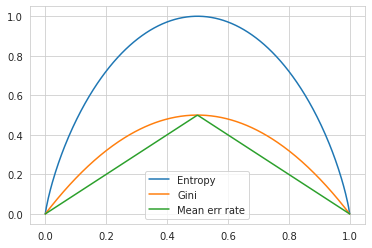

In [ ]:
def entropy(counts):
    p_x = counts/(np.sum(counts)+1e-200)
    return -np.sum(p_x*np.log2(p_x+1e-200))

def gini(counts):
    norm = counts/sum(counts)
    return 1-np.sum(norm**2)

def mean_err_rate(counts):
    return 1-np.max(counts/np.sum(counts))

plt.figure()
X = np.linspace(0, 1, 300)
plt.plot(X, [entropy(np.array([x, 1-x])) for x in X], label='Entropy')
plt.plot(X, [gini(np.array([x, 1-x])) for x in X], label='Gini')
plt.plot(X, [mean_err_rate(np.array([x, 1-x])) for x in X], label='Mean err rate')
plt.legend()
plt.show()

## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below, as indicated by the TODO comments.

In [ ]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """

    def __init__(self, attr, purity_gain):
        self.attr = attr
        self.purity_gain = purity_gain

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a subtree for each value that an attribute may take.

In [ ]:
class CategoricalMultivalueSplit(AbstractSplit):
    def __init__(self, attr, purity_gain, majority_group):
        super(CategoricalMultivalueSplit, self).__init__(attr, purity_gain)
        self.majority_group = majority_group

    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        
        df_unk = df[(df[self.attr] == pd.NA)]
        df = df[(df[self.attr] != pd.NA)]

        for group_name, group_df in df.groupby(self.attr):
            if group_name == self.majority_group:
            
                group_df = pd.concat([group_df, df_unk])

            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):

        assert self.attr in x
        # Return the subtree for the given example
        if x[self.attr] in self.subtrees:
            return self.subtrees[x[self.attr]]
        else:
            return self.subtrees[self.majority_group]

    def iter_subtrees(self):
        return self.subtrees.values()

    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f"{id(parent)}", f"{id(child)}", label=f"{split_name}")

In [ ]:
def get_categorical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    # Compute the purity after the split
    
    df = df[(df[attr] != pd.NA)]

    mean_child_purity = np.sum([purity_fun(group_df.value_counts('target')) * len(group_df) for group_name, group_df in df.groupby(attr)]) / len(df)

    
    majority_group = df.value_counts(attr).index.values[0]

    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - mean_child_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())+1e-200

    split = CategoricalMultivalueSplit(attr, purity_gain, majority_group)
    print(mean_child_purity)

    return split, purity_gain

In [ ]:
def get_split(df, criterion="infogain", nattrs=None):
    """Find best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of smaples in the node to be split
        - criterion: spluis selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """
    # Implement termination criteria:
    # TermCrit1: Node is pure
    target_value_counts = df["target"].value_counts()
    if len(target_value_counts) == 1:
        return None
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.

    possible_splits = [column for column in df.columns if column!="target"]  # possible_splits must be a list
    
    assert "target" not in possible_splits
    #    Terminate early if none are possivle
    if not possible_splits:
        return None

    # Get the base purity measure and the purity function
    if criterion in ["infogain", "infogain_ratio"]:
        purity_fun = entropy
    elif criterion in ["mean_err_rate"]:
        purity_fun = mean_err_rate
    elif criterion in ["gini"]:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # restrict possible_splits to a few radomly selected attributes
    if nattrs is not None:
         random.shuffle(possible_splits)
         possible_splits = possible_splits[:nattrs]
    
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner
            # similar to categorical ones
            split_sel_fun = get_numrical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity

        split, purity_gain = split_sel_fun(
            df,
            base_purity,
            purity_fun,
            attr,
            normalize_by_split_entropy=criterion.endswith("ratio"),
        )

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    


    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [ ]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values,
        # TODO: remove this for bonus problem #2.4

        # Technicality:
        # We need to let subtrees know about all targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)

        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
        }

        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)

    def prune_confidence_interval(self, conf_lvl):

        node_sample_error = 1 - np.max(self.counts)/np.sum(self.counts) 
        node_up_confidence = node_sample_error + conf_lvl * np.sqrt(node_sample_error*(1-node_sample_error)/np.sum(self.counts))
        self.info['node_conf'] = node_up_confidence
        

        if self.split != None:
            to_pop = []
            for name, subtree in self.split.subtrees.items():
                subtree.prune_confidence_interval(conf_lvl)
                child_sample_error = 1 - np.max(subtree.counts)/np.sum(subtree.counts)
                child_up_confidence = child_sample_error + conf_lvl * np.sqrt(child_sample_error*(1-child_sample_error)/np.sum(subtree.counts))
                if node_up_confidence < child_up_confidence:
                    to_pop.append(name)

            for name in to_pop:
                self.split.subtrees.pop(name)

            #mean_child_up_confidence = sum_child_up_confidence/len(self.split.iter_subtrees())
            #self.info['mean_child_conf'] = mean_child_up_confidence

            #if node_up_confidence < mean_child_up_confidence:
                #self.split.subtrees.pop(name)
                #self.info.pop('mean_child_conf')

    def purity_inc_over_split(self, column):
        res = []
        if self.split is not None:

            for subtree in self.split.iter_subtrees():
                res.extend(subtree.purity_inc_over_split(column))

            if self.split.attr == column and self.split.purity_gain < 2:
                res.extend([self.split.purity_gain])
        
        return res

    def get_target_distribution(self, sample):
        if self.split is not None:
            subtree = self.split(sample)
            if subtree is not None:
                return subtree.get_target_distribution(sample)
        
        return self.counts / self.info['num_samples']

    def error_rate(self, train_df):

        for cv_train_idx, cv_test_idx in KFold(n_splits=5).split(train_df):
            self.reset_tree()
            self.count_sample(train_df.iloc[cv_train_idx])
            self.score(train_df.iloc[cv_test_idx])

    def prune_error_rate(self):
        if self.split is not None:
            err = 0
            for subtree in self.split.iter_subtrees():
                if subtree.info.get('error') is not None:
                    subtree.prune_error_rate()
                    err += subtree.info['error']
            
            err /= len(self.split.subtrees.keys())
            if err > self.info['error']:
                self.split = None


    def reset_tree(self):
        self.counts[:] = 0
        self.info["num_samples"] = 0
        if self.split is not None:
            for subtree in self.split.iter_subtrees():
                subtree.reset_tree()
    
    def count_sample(self, train_df, full_info=False):
        self.counts = train_df["target"].value_counts()
        self.info["num_samples"] = len(train_df)
        if full_info:
            self.info["entropy"] = entropy(self.counts)
            self.info["gini"] = gini(self.counts)

        if self.split is not None:
            attr = self.split.attr
            for subtree_name, subtree in self.split.subtrees.items():
                subtree.count_sample(train_df[train_df[attr]==subtree_name])

    def score(self, test_df):

        if self.info["num_samples"] > 0 and len(test_df) > 0:
            node_target = self.counts.idxmax()
            if self.info.get('good') is None:
                self.info['good'] = len(test_df[test_df['target']==node_target])
            else:
                self.info['good'] += len(test_df[test_df['target']==node_target])
            
            if self.info.get('bad') is None:
                self.info['bad'] = len(test_df[test_df['target']!=node_target])
            else:
                self.info['bad'] += len(test_df[test_df['target']!=node_target])

            self.info['error'] = self.info['bad']/(self.info['good']+self.info['bad'])
        
        if self.split is not None:
            attr = self.split.attr
            for subtree_name, subtree in self.split.subtrees.items():
                subtree.score(test_df[test_df[attr]==subtree_name])


    def classify(self, sample):
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        leaf_dist = self.get_target_distribution(sample)
        return leaf_dist.idxmax()
        
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

In [ ]:
mushroom_df[mushroom_df=='?'] = pd.NA

0.9502711949370876
0.9704776640986875
0.9630186138962564
0.8066884111112408
0.0929929194884606
0.9849028696218441
0.8981847128758902
0.7689135217244144
0.582090373456329
0.9915511243027961
0.5989300721551621
0.7143422976539759
0.7271734234797138
0.7452227234102207
0.7576523303448939
0.9990678968724603
0.9752508807515435
0.9606152276293699
0.6810463860789229
0.5183629791875449
0.7971098778056079
0.8422342922673685
0.17147646195127472
0.19805765931727878
0.12052447688727533
0.21326013182381132
0.2141367567812511
0.21134161301217153
0.2095207557604492
0.19074038973442725
0.12788999402302256
0.1516904657612051
0.13571071085908348
0.19031625771715768
0.16309544042267485
0.17799036876428312
0.15345591226452263
0.2141367567812511
0.2003564035917428
0.1901843900805035
0.2133299685307595
0.06919954186639896
0.17027355404056413
0.15500175632269342
0.35815464370948963
0.30235332158832307
0.17865886704639855
0.37912386805453824
0.39124356362925566
0.39124356362925566
0.37826510509729655
0.15384615

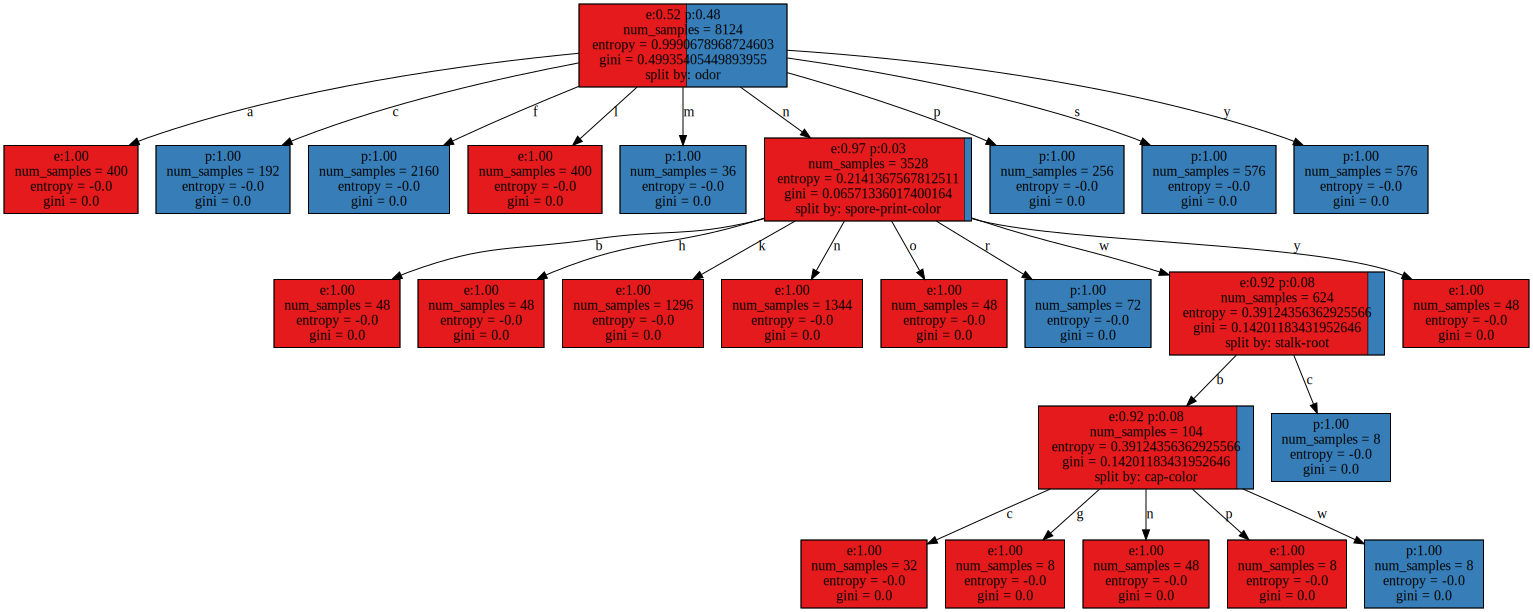

In [ ]:
# Train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.

# Note: for this code to work you must fix the todos in the previous sections


mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

0.9502711949370876
0.9704776640986875
0.9630186138962564
0.8066884111112408
0.0929929194884606
0.9849028696218441
0.8981847128758902
0.7689135217244144
0.582090373456329
0.9915511243027961
0.5989300721551621
0.7143422976539759
0.7271734234797138
0.7452227234102207
0.7576523303448939
0.9990678968724603
0.9752508807515435
0.9606152276293699
0.6810463860789229
0.5183629791875449
0.7971098778056079
0.8422342922673685
0.17147646195127472
0.19805765931727878
0.12052447688727533
0.21326013182381132
0.2141367567812511
0.21134161301217153
0.2095207557604492
0.19074038973442725
0.12788999402302256
0.1516904657612051
0.13571071085908348
0.19031625771715768
0.16309544042267485
0.17799036876428312
0.15345591226452263
0.2141367567812511
0.2003564035917428
0.1901843900805035
0.2133299685307595
0.06919954186639896
0.17027355404056413
0.15500175632269342
0.13560466380848665
0.15632916471780642
0.013634926461498031
0.24934577223910742
0.25146396423889
0.25146396423889
0.2479247507331145
0.24792475073311

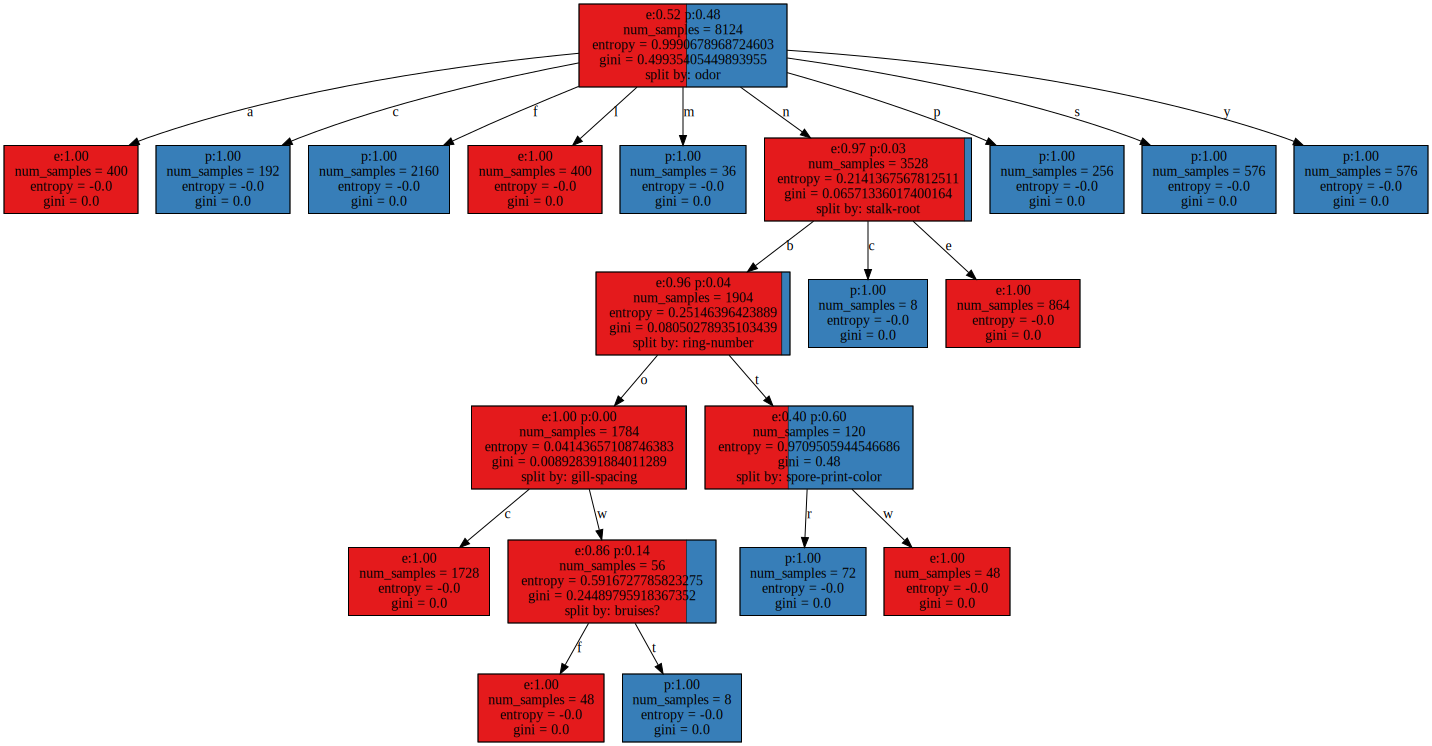

In [ ]:
mushroom_tree = Tree(mushroom_df, criterion='infogain_ratio')
mushroom_tree.draw()

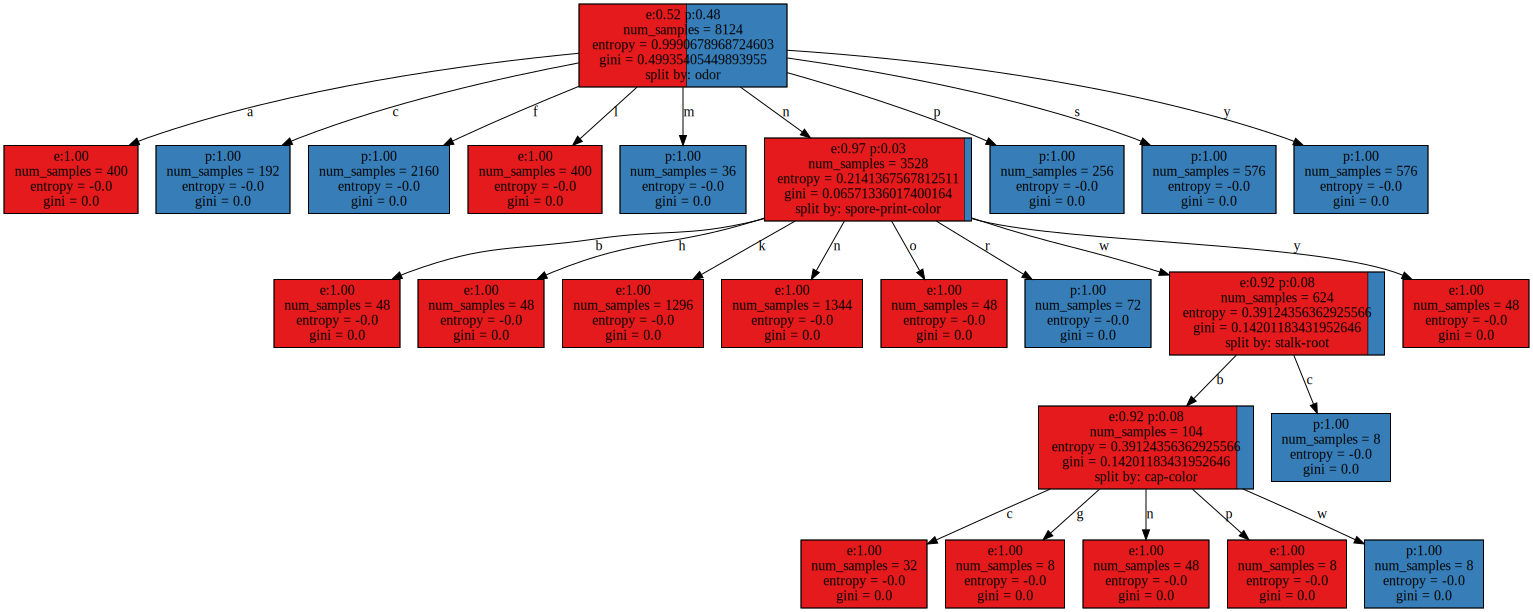

In [ ]:
mushroom_df[mushroom_df=='?'] = pd.NA
mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

**Answer the questions below**
1. How many samples are classified correctly by a tree with only one split?
2. Is the tree different when different purity functions are used?


## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [ ]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, purity_gain, th, majority_group):
        super(NumericalSplit, self).__init__(attr, purity_gain)
        self.th = th
        self.majority_group = majority_group

    def build_subtrees(self, df, subtree_kwargs):

        df_unk = df[(df[self.attr] == pd.NA)]
        df = df[(df[self.attr] != pd.NA)]
        if self.majority_group == 0:
            self.subtrees = (
                Tree(pd.concat([df[df[self.attr] <= self.th], df_unk]), **subtree_kwargs),
                Tree(df[df[self.attr] > self.th], **subtree_kwargs),
            )
        else: 
            self.subtrees = (
                Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
                Tree(pd.concat([df[df[self.attr] > self.th],df_unk]), **subtree_kwargs),
            )

    def __call__(self, x):
        # return the sobtree for the data sample `x`
        
        assert(self.attr in x)

        if x[self.attr] is pd.NA:
            return self.subtrees[self.majority_group]

        if x[self.attr] <= self.th:
            return self.subtrees[0]
        else:
            return self.subtrees[1]

    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[0])}", label=f"<= {self.th:.2f}")
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[1])}", label=f"> {self.th:.2f}")


def get_numrical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    df = df[(df[attr] != pd.NA)]
    attr_df = df[[attr, "target"]].sort_values(attr)
    targets = attr_df["target"]
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None  # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    purity = None
    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0

        # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)
        # the loop should return the best possible split.
        # TODO: update left_counts and right_counts

        right_counts[targets.iloc[row_i]] -= 1
        left_counts[targets.iloc[row_i]] += 1
       
        if attribute_value == next_attribute_value:
            continue

        # TODO: now consider the split at split_threshold and save it if it the best one

        mean_purity = (purity_fun(right_counts) * right_counts.sum() + purity_fun(left_counts) * left_counts.sum()) / N

        purity_gain = parent_purity - mean_purity
        if normalize_by_split_entropy:
                purity_gain /= entropy([right_counts.sum(), left_counts.sum()])+1e-200

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain

            if np.sum(right_counts) > np.sum(left_counts):
                best_split = NumericalSplit(attr, best_purity_gain, split_threshold, 0)
            else:
                best_split = NumericalSplit(attr, best_purity_gain, split_threshold, 1) 

    return best_split, best_purity_gain

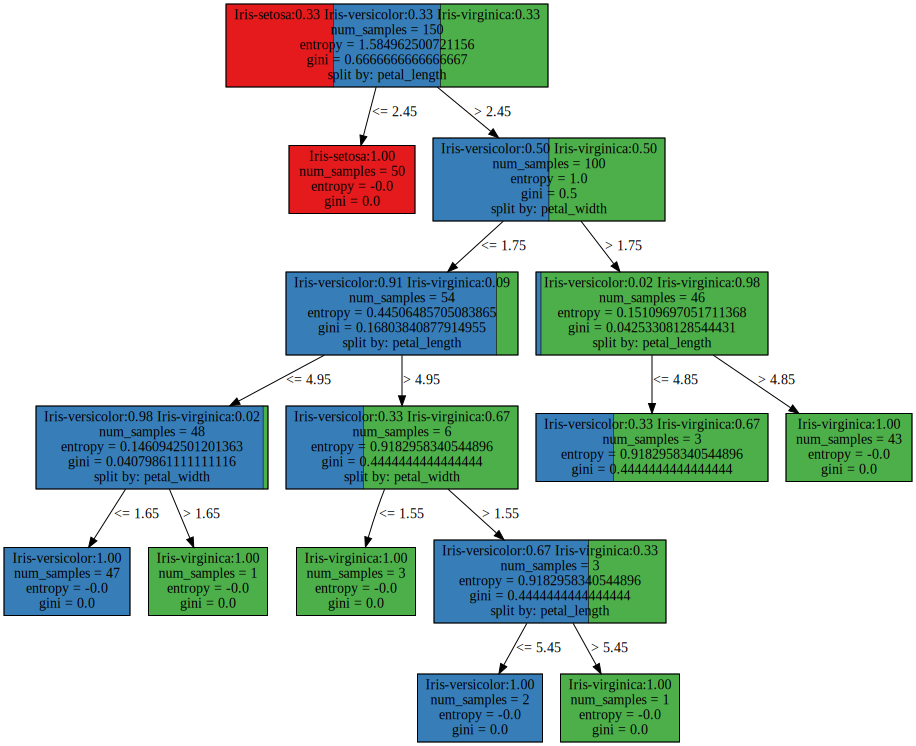

In [ ]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[["petal_length", "petal_width", "target"]]
iris_tree = Tree(iris2d)
iris_tree.draw()

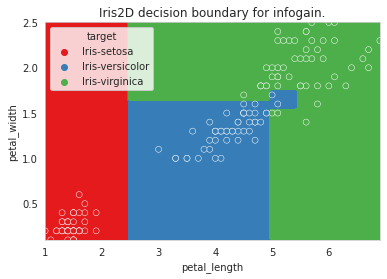

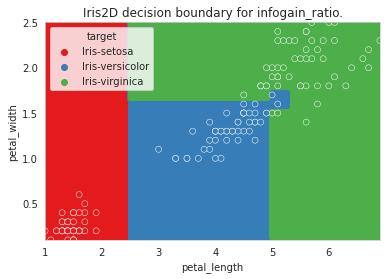

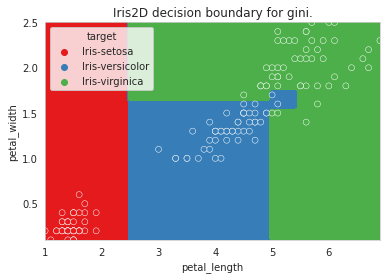

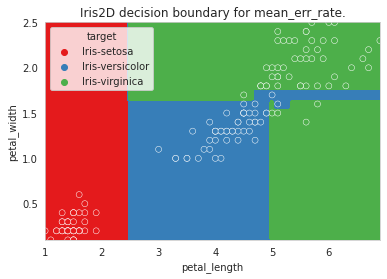

In [ ]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty((len(mesh_data),))

for criterion in ["infogain", "infogain_ratio", "gini", "mean_err_rate"]:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(
        mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap="Set1", vmin=0, vmax=7
    )
    sns.scatterplot(
        x="petal_length", y="petal_width", hue="target", data=iris_df, palette="Set1",
    )

## Decision Tree Task 4: Handling missing data [2bp]

Implement support for missing values. A possible strategy does the following:
each time (both during training and testing) we encounter a split for which the smaple misses attribute's value, we a weighted copy of the sample down each subtree, with the weight equal to the probaiblity that the child subtree is selected (i.e. proportional to number of samples put into the subtree.).

In [ ]:
mushroom_tree = Tree(mushroom_df)
sample = mushroom_df.loc[5].copy()
print('r:', mushroom_tree.classify(sample))
sample['odor'] = pd.NA
print('r:', mushroom_tree.classify(sample))

a
r: e
n
k
r: e


In [ ]:
iris_tree = Tree(iris2d)
sample = iris2d.loc[98].copy()
print('r:', iris_tree.classify(sample))
sample['petal_length'] = pd.NA
print('r:', iris_tree.classify(sample))

1
0
0
0
r: Iris-versicolor
1
0
0
0
r: Iris-versicolor


## Decision Tree Task 5: Pruning [2-4bp]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning
Build a tree using all the data. Then split the training set into 10 crossvalidation subsets. Then in a loop over the tesintg crossvalidation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning
Build the deicision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.

As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

0.08396946564885496


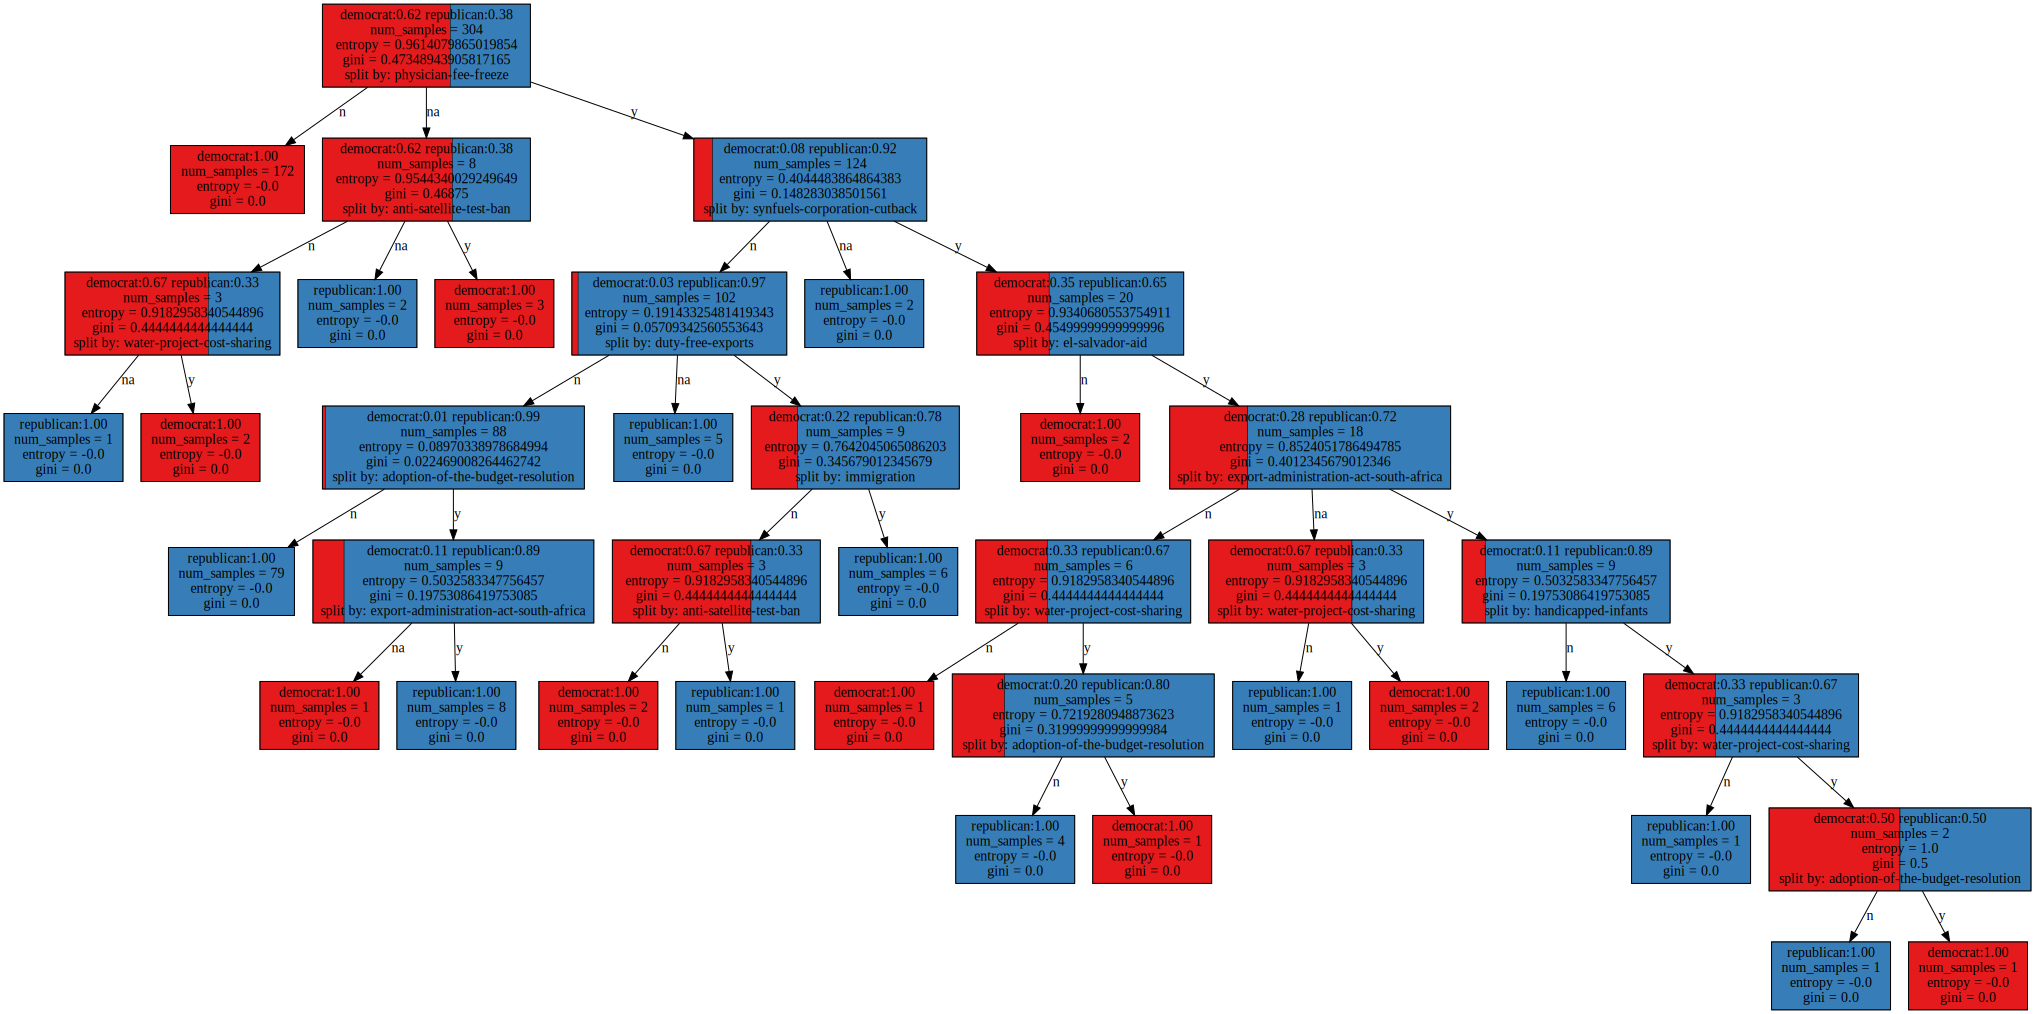

In [ ]:
def error(Tree, test_df):
    err = 0
    for _, sample in test_df.iterrows():
        if Tree.classify(sample) != sample['target']:
            err+=1
    print(err/len(test_df))

vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(vote_df, test_size=0.3)

vote_Tree = Tree(vote_train_df)
error(vote_Tree, vote_test_df)
vote_Tree.draw()

0.06870229007633588


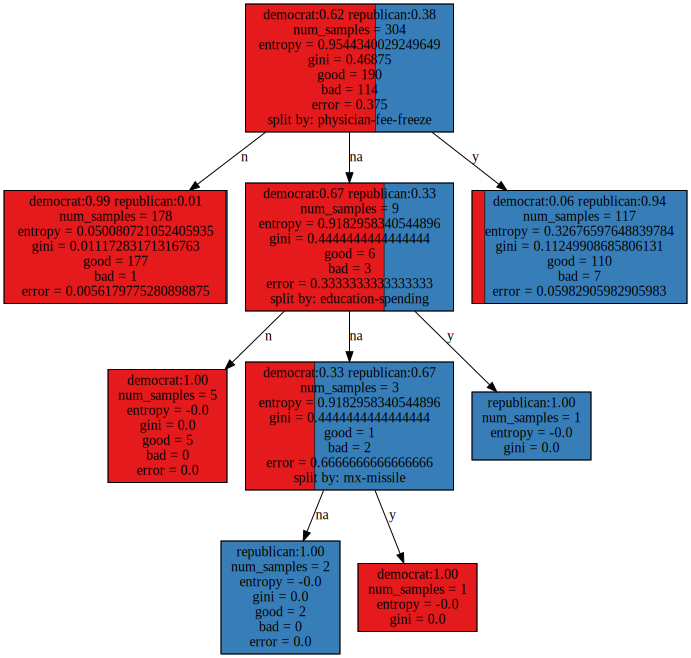

In [ ]:
vote_Tree_1 = copy.deepcopy(vote_Tree)
vote_Tree_1.error_rate(vote_train_df)
vote_Tree_1.prune_error_rate()
vote_Tree_1.count_sample(vote_train_df, True)
error(vote_Tree_1, vote_test_df)
vote_Tree_1.draw()

0.04580152671755725


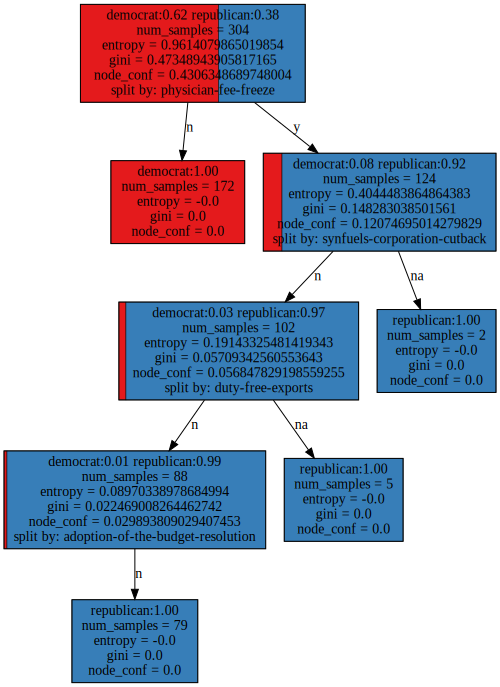

In [ ]:
vote_Tree_2 = copy.deepcopy(vote_Tree)
vote_Tree_2.prune_confidence_interval(1.64)
error(vote_Tree_2, vote_test_df)
vote_Tree_2.draw()

# Problem 4: Random Forest [3p]

We will use the german credit dataset. Please split it into a training and testing set using a 70%-30% ratio.

Next train and test a regular decision tree on it.

Then:
1. Implement randomized tree bulding, by restricting the set of attrbutes considered for data spltting in the tree building code below (the `nattrs` argument). Alternatively, you can use trees from sklearn (se below).
2. Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute the tree's test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

**Note:** This assignment assumes that you use either your own implementation of the decision tree from Problem 3, or the implementation of [trees from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since sklearn's trees don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. last year's AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode the categorical variables using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(german_df, test_size=0.3)
display(train_df)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,target
685,A14,60,A32,A40,6527,A65,A73,4,A93,A101,4,A124,34,A143,A153,1,A173,2,A192,A201,1
34,A13,12,A32,A42,1474,A61,A72,4,A92,A101,1,A122,33,A141,A152,1,A174,1,A192,A201,1
107,A12,12,A32,A40,6078,A61,A74,2,A93,A101,2,A123,32,A143,A152,1,A173,1,A191,A201,1
57,A14,36,A34,A43,9566,A61,A73,2,A92,A101,2,A123,31,A142,A152,2,A173,1,A191,A201,1
772,A14,21,A34,A41,3275,A61,A75,1,A93,A101,4,A123,36,A143,A152,1,A174,1,A192,A201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,A14,12,A34,A43,1240,A65,A75,4,A92,A101,2,A121,38,A143,A152,2,A173,1,A192,A201,1
237,A12,21,A32,A49,2767,A62,A75,4,A91,A101,2,A123,61,A141,A151,2,A172,1,A191,A201,2
695,A14,6,A32,A41,1236,A63,A73,2,A93,A101,4,A122,50,A143,A151,1,A173,1,A191,A201,1
766,A11,30,A32,A42,3108,A61,A72,2,A91,A101,4,A122,31,A143,A152,1,A172,1,A191,A201,2


In [ ]:
g_Tree = Tree(train_df)
error(g_Tree, test_df)
g_Tree.prune_confidence_interval(1.60)
error(g_Tree, test_df)

0.34
0.2966666666666667


In [ ]:
class RandomForest:

    def __init__(self, Tree, criterion, nattrs, bootstrap_size=700):

        self.Tree = Tree
        self.criterion = criterion
        self.nattrs = nattrs
        self.bootstrap_size = bootstrap_size
        self.forest = []
        self.bootstrap_dfs = []
        self.tree_errors = {}

    def add_trees(self, number_of_trees, train_df, bootstrap=True):
        
        for _ in range(number_of_trees):
        

            if bootstrap:
                train_idx = np.random.randint(low = 0, high = len(train_df), size = self.bootstrap_size)
                train_df = train_df.iloc[train_idx]

            self.forest.append(self.Tree(train_df, criterion = self.criterion , nattrs = self.nattrs))
            self.bootstrap_dfs.append(train_df)

    def calculate_tree_error(self, idx, test_df):
        err = 0
        for _, sample in test_df.iterrows():
            if self.forest[idx].classify(sample) != sample['target']:
                err+=1
        return err/len(test_df)

    def calculate_forest_error(self, test_df):
        err = 0
        for _, sample in test_df.iterrows():
            if self.classify(sample) != sample['target']:
                err+=1
        return err/len(test_df)
    
    def classify(self, sample):

        res = []
        for tree in self.forest:
            res.append(tree.classify(sample))

        return mode(res)[0][0]

    def oob_error_tree(self, idx, train_df):

        assert (len(self.forest)==len(self.bootstrap_dfs))
        
        err = 0
        counter = 0 

        bootstrap_df = self.bootstrap_dfs[idx]
        tree = self.forest[idx]

        for _, sample in train_df.iterrows():
            res = []
            if not (bootstrap_df == sample).all(1).any():
                 counter+=1
                 res.append(tree.classify(sample))
            
            if len(res) > 0:
                pred = mode(res)[0][0]
                if pred != sample['target']:
                    err += 1
        
        return err/counter

    def oob_error_forest(self, train_df):

        assert (len(self.forest)==len(self.bootstrap_dfs))
        
        err = 0
        for _, sample in train_df.iterrows():
            res = []
            for bootstrap_df, tree in zip(self.bootstrap_dfs, self.forest):
                if not (bootstrap_df == sample).all(1).any():
                    res.append(tree.classify(sample))
            
            if len(res) > 0:
                pred = mode(res)[0][0]
                if pred != sample['target']:
                    err += 1
        
        return err/len(train_df)
    
    def trees_mean_error(self, test_df):

        err = 0
        for idx in np.arange(len(self.forest)):
            err += self.calculate_tree_error(idx, test_df)
        
        return err/len(self.forest)

    def feature_importance_purity(self, column):

        res = []
        for tree in self.forest:
            tree_purt_inc = np.array(tree.purity_inc_over_split(column)).flatten()
            print(tree_purt_inc)
            if len(tree_purt_inc) != 0:
                res.append(tree_purt_inc.mean())

        return np.array(res).mean()
        

    def trees_agreement(self, test_df):

        agr = 0
        for _, sample in test_df.iterrows():
            res = []
            for tree in self.forest:
                res.append(tree.classify(sample))
            
            pred = mode(res)[0][0]
            agr += np.sum(pred == res)/len(res)

        return agr/len(test_df)

In [ ]:
for nattr in range(1,4):
    print("------------------------------------ nattr {} ------------------------------------".format(nattr))
    forest = RandomForest(Tree=Tree, criterion='infogain_ratio', nattrs=nattr, bootstrap_size=700)
    for i in range(1,31):
        forest.add_trees(1, train_df, bootstrap=True)
        print("------------------------------------ Tree {} ------------------------------------".format(i))
        print("Forest Error: {:.2f}% \t Tree Error: {:.2f}% \t OBB Tree: {:.2f}%".format(
            forest.calculate_forest_error(test_df)*100, forest.calculate_tree_error(-1, test_df)*100, forest.oob_error_tree(-1, train_df)*100))
   
    print("Forest Test error: {:.2f}%".format(forest.calculate_forest_error(test_df)*100))
    print("Forest OOB: {:.2f}%".format(forest.oob_error_forest(train_df)*100))
    print("Trees mean error: {:.2f}%".format(forest.trees_mean_error(test_df)*100))
    print("Mean Tree Agreement: {:.2f}%".format(forest.trees_agreement(test_df)*100))

------------------------------------ nattr 1 ------------------------------------
------------------------------------ Tree 1 ------------------------------------
Forest Error: 34.67% 	 Tree Error: 34.67% 	 OBB Tree: 34.87%
------------------------------------ Tree 2 ------------------------------------
Forest Error: 30.00% 	 Tree Error: 35.00% 	 OBB Tree: 40.91%
------------------------------------ Tree 3 ------------------------------------
Forest Error: 29.67% 	 Tree Error: 31.00% 	 OBB Tree: 29.32%
------------------------------------ Tree 4 ------------------------------------
Forest Error: 25.67% 	 Tree Error: 26.33% 	 OBB Tree: 34.82%
------------------------------------ Tree 5 ------------------------------------
Forest Error: 26.33% 	 Tree Error: 37.33% 	 OBB Tree: 35.69%
------------------------------------ Tree 6 ------------------------------------
Forest Error: 25.67% 	 Tree Error: 32.67% 	 OBB Tree: 42.08%
------------------------------------ Tree 7 ----------------------

# Problem 5: Implement Variable importance using Random Forests [2p]

Implement the two measures of variable importance in a Random Forest:
1. Total purity inclreas for all splits using this variable
2. Forest performance decrease on replacing an attribute with random data.

Then analyze the variable importance on some datasets (e.g. mushroom and german credit).

## MUSHROOM DF

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(mushroom_df, test_size=0.1)

In [ ]:
forest = RandomForest(Tree=Tree, criterion='infogain_ratio', nattrs=1)
forest.add_trees(20, train_df, bootstrap=True)
error = forest.calculate_forest_error(test_df)
print("Forest Test error: {:.2f}%".format(error*100))

In [ ]:
res = []

for column in tqdm(test_df, total=test_df.shape[1]):
    if column != 'target':
        res.append({'column': column, 'purity_inc': forest.feature_importance_purity(column)})

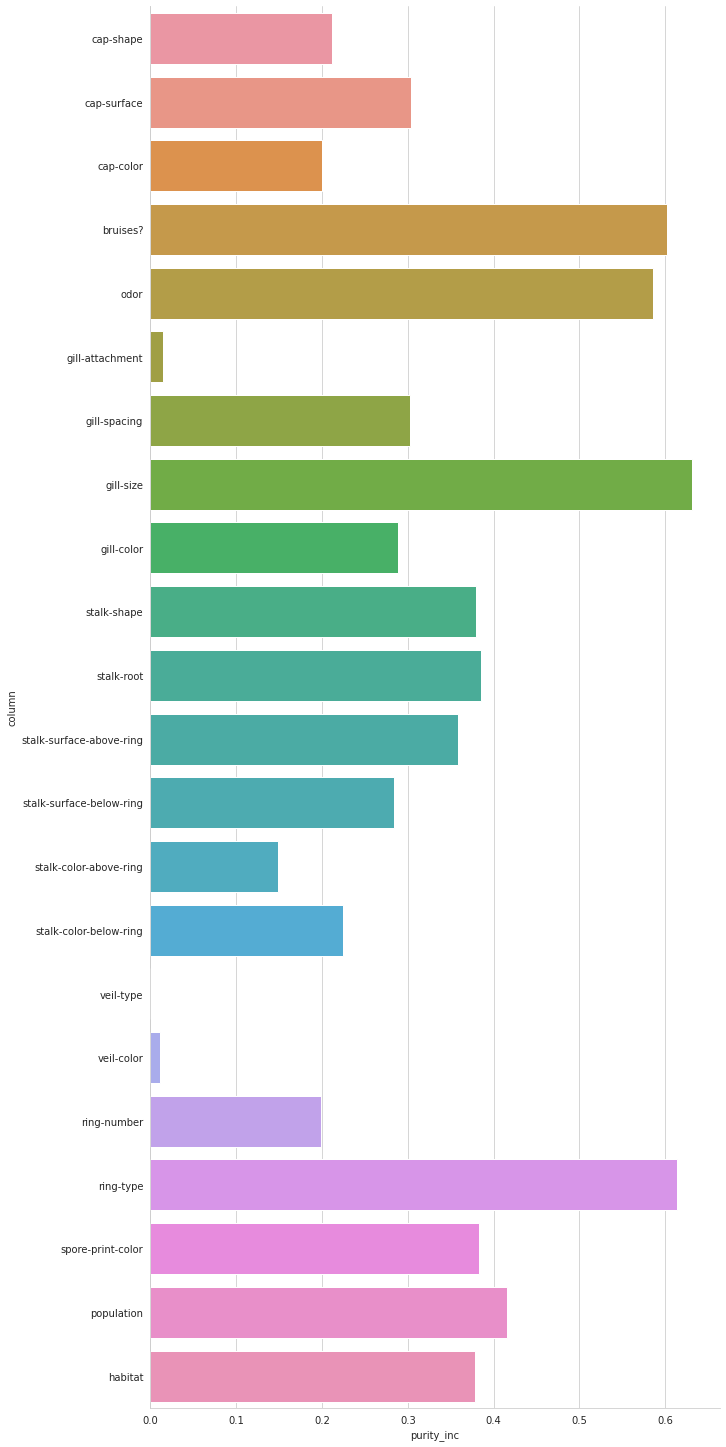

In [ ]:
sns.catplot(x = 'purity_inc', y = 'column', data=pd.DataFrame(res), kind = 'bar', height=20, aspect=0.5)

In [ ]:
res = []
repetition = 15

for column in tqdm(test_df, total=test_df.shape[1]):
    rep_df = test_df.copy()
    if column != 'target':
        for _ in range(repetition):
            rep_df[column] = np.random.permutation(rep_df[column])
            rep_error = forest.calculate_forest_error(rep_df)
            res.append({'column': column, 'error': rep_error-error})


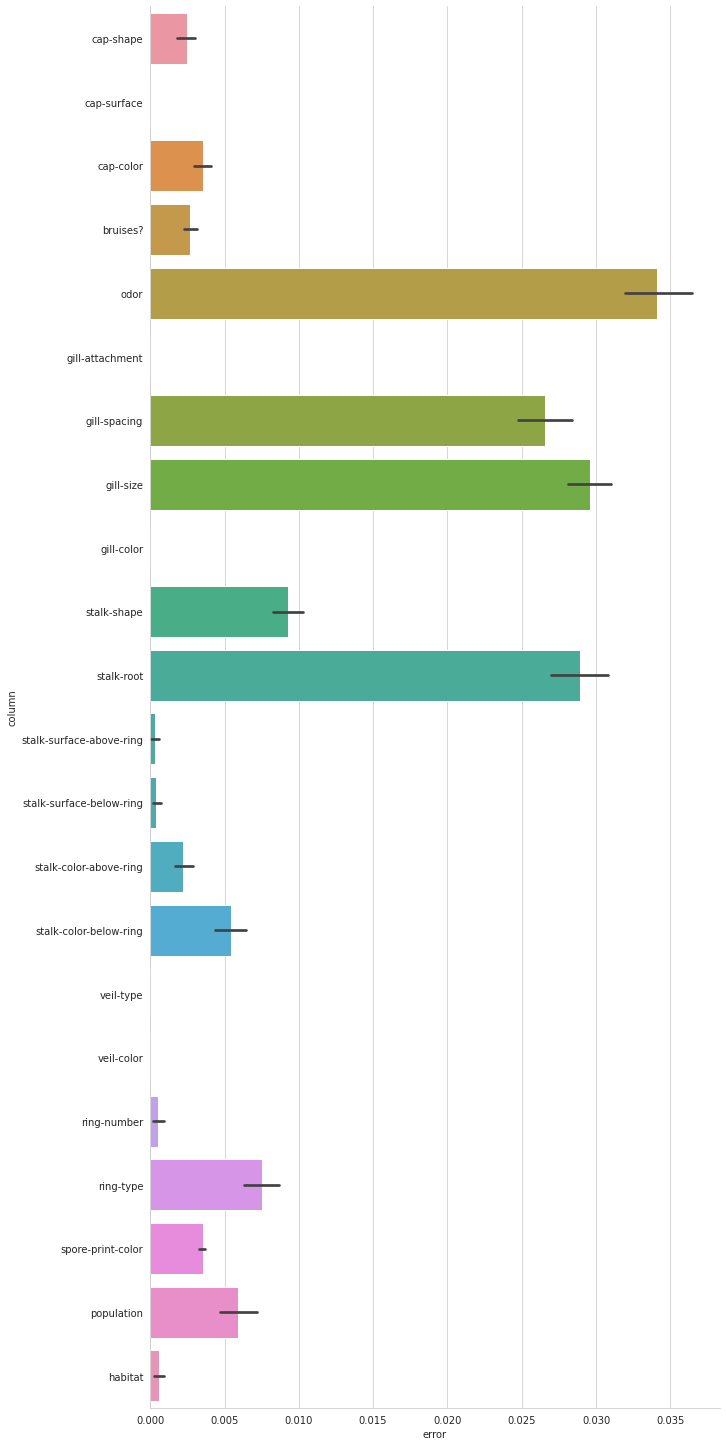

In [ ]:
sns.catplot(x = 'error', y = 'column', data=pd.DataFrame(res), kind = 'bar', height=20, aspect=0.5)

## German Credit

In [ ]:
train_df, test_df = sklearn.model_selection.train_test_split(german_df, test_size=0.3)

In [ ]:
forest = RandomForest(Tree=Tree, criterion='infogain_ratio', nattrs=1)
forest.add_trees(20, train_df, bootstrap=True)
error = forest.calculate_forest_error(test_df)
print("Forest Test error: {:.2f}%".format(error*100))

In [ ]:
res = []

for column in tqdm(test_df, total=test_df.shape[1]):
    if column != 'target':
        res.append({'column': column, 'purity_inc': forest.feature_importance_purity(column)})

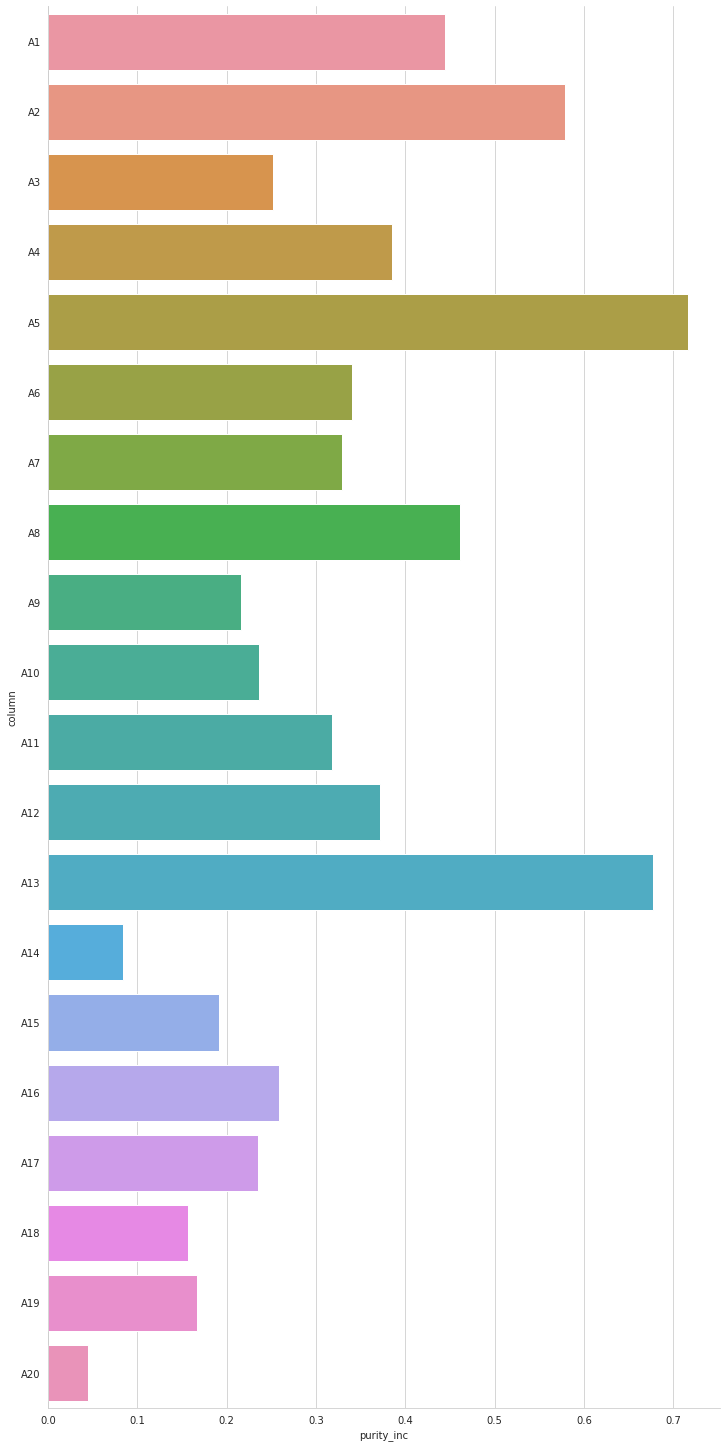

In [ ]:
sns.catplot(x = 'purity_inc', y = 'column', data=pd.DataFrame(res), kind = 'bar', height=20, aspect=0.5)

In [ ]:
res = []
repetition = 15

for column in tqdm(test_df, total=test_df.shape[1]):
    rep_df = test_df.copy()
    if column != 'target':
        for _ in range(repetition):
            rep_df[column] = np.random.permutation(rep_df[column])
            rep_error = forest.calculate_forest_error(rep_df)
            res.append({'column': column, 'error': rep_error-error})


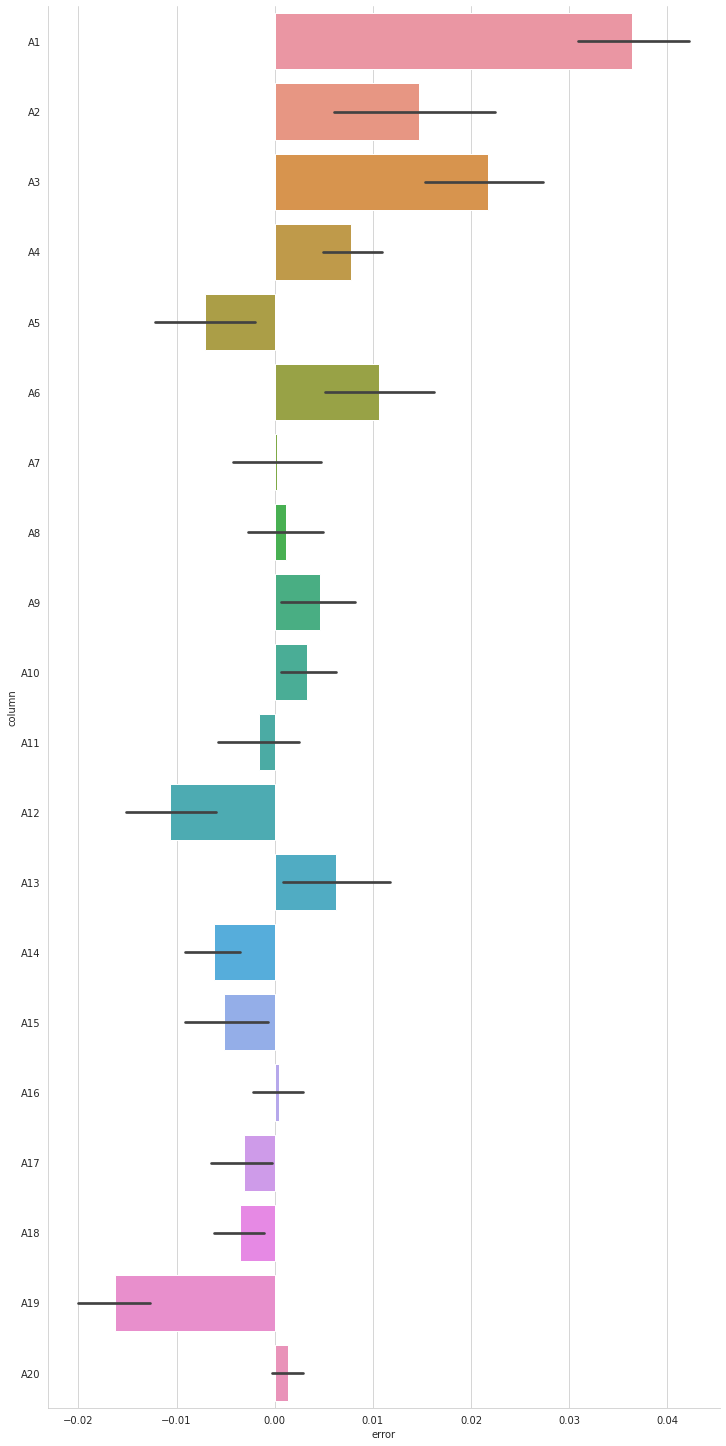

In [ ]:
sns.catplot(x = 'error', y = 'column', data=pd.DataFrame(res), kind = 'bar', height=20, aspect=0.5)

# Problem 5: More analysis using Random Forests [3bp]

Implement the following extra analysis using a Random Forest:
- data clustering
- data visualizatoin using MultiDimensional Scaling (https://en.wikipedia.org/wiki/Multidimensional_scaling, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

For details see https://www.stat.berkeley.edu/~breiman/Using_random_forests_v4.0.pdf.